<a href="https://colab.research.google.com/github/janna-in-sf/DataSF-311-Cases/blob/main/DataSF_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DataSF Project

Data from Data SF on 311 requests/cases to city of San Francisco. 

*    See: https://data.sfgov.org/City-Infrastructure/311-Cases/vw6y-z8j6 
*   Started: January 2023
*   Status: Work in Progress
*   Janna Voss



## Imports

In [1]:
from google.colab import drive
import pandas as pd
import numpy as np
import statistics
import matplotlib.pyplot as plt
import seaborn as sns

import math
import time
from datetime import datetime

## Load Input File

### Mount Drive

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


### Read CSV File

In [72]:
# set variables
file_path = '/content/drive/MyDrive/colab_files/data/'
file_name = '311_Cases.csv'
absolute_file_name = file_path + file_name

# hardcoded column names for cols to keep from input CSV file
"""
col_names = ['CaseID', 'Opened', 'Closed', 'Updated','Status', 'Status Notes',
             'Responsible Agency', 'Category', 'Request Type', 'Request Details',
             'Address', 'Street', 'Supervisor District', 'Neighborhood', 
             'Police District','Latitude', 'Longitude', 'Source']
col_types = {'Status': 'category', 'Supervisor District':'category', 
             'Police District':'category', 'Latitude': 'float32', 
             'Longitude': 'float32','Source':'category'}
"""

col_names = ['CaseID', 'Opened', 'Closed', 'Updated','Status', 'Status Notes',
             'Responsible Agency', 'Category', 'Request Type', 'Request Details',
             'Address', 'Street', 'Supervisor District', 'Neighborhood', 
             'Police District', 'Source']
date_col_names = ['Opened','Closed','Updated']
category_col_types = {'Status': 'category', 'Supervisor District':'category', 
             'Police District':'category','Source':'category'}
col_index_name = 'CaseID'

In [73]:
# Load the file
print('Loading file: ', absolute_file_name,'\n')

rows_to_load = 25000
#csv_date_format = '%m/%d/%Y %I:%M:%S %p'

start = time.time()
print("Start Time =", datetime.now().strftime("%H:%M:%S"))


df = pd.read_csv(absolute_file_name, usecols=col_names, 
                 dtype=category_col_types, index_col= col_index_name, 
                 nrows=rows_to_load, parse_dates=date_col_names)

#df[date_col_names] = df[date_col_names].apply(pd.to_datetime)

end = time.time()
print("End Time   =", datetime.now().strftime("%H:%M:%S"))
print('Elapsed time:',end - start, 'seconds')
print('\nLoaded file with (rows, cols) = ',df.shape,'\n')

print('Before converting col names', df.columns, '\n')
# rename columns that contain spaces and convert to lower case
df.columns = df.columns.str.replace(' ', '_')
df= df.rename(columns=str.lower)
# also convert list of date col names
date_col_names = [x.lower() for x in date_col_names]
print('After converting col names', df.columns)
df.head(3)

Loading file:  /content/drive/MyDrive/colab_files/data/311_Cases.csv 

Start Time = 22:32:13
End Time   = 22:32:24
Elapsed time: 10.647878646850586 seconds

Loaded file with (rows, cols) =  (25000, 15) 

Before converting col names Index(['Opened', 'Closed', 'Updated', 'Status', 'Status Notes',
       'Responsible Agency', 'Category', 'Request Type', 'Request Details',
       'Address', 'Street', 'Supervisor District', 'Neighborhood',
       'Police District', 'Source'],
      dtype='object') 

After converting col names Index(['opened', 'closed', 'updated', 'status', 'status_notes',
       'responsible_agency', 'category', 'request_type', 'request_details',
       'address', 'street', 'supervisor_district', 'neighborhood',
       'police_district', 'source'],
      dtype='object')


,opened,closed,updated,status,status_notes,responsible_agency,category,request_type,request_details,address,street,supervisor_district,neighborhood,police_district,source
CaseID,,,,,,,,,,,,,,,
6501676,2016-11-06 10:10:45,2016-11-07 09:11:12,2016-11-07 09:11:12,Closed,Case Resolved - 10-98,DPW Ops Queue,Encampments,Encampment Reports,Encampment Cleanup,"2953 HARRISON ST, SAN FRANCISCO, CA, 94110",HARRISON ST,9,Mission,MISSION,Mobile/Open311
6484030,2016-11-01 11:26:26,2016-11-01 16:59:33,2016-11-01 16:59:33,Closed,Case Resolved - Pickup completed,Recology_Abandoned,Street and Sidewalk Cleaning,Bulky Items,Mattress,Intersection of ISADORA DUNCAN LN and TAYLOR ST,ISADORA DUNCAN LN,3,Lower Nob Hill,CENTRAL,Phone
6505388,2016-11-07 11:08:09,2016-11-12 16:40:17,2016-11-12 16:40:17,Closed,Case Resolved - entire area is trashed out nee...,DPW Ops Queue,Street and Sidewalk Cleaning,Bulky Items,Electronics,Intersection of ARELIOUS WALKER DR and REVERE AVE,ARELIOUS WALKER DR,10,Hunters Point,BAYVIEW,Mobile/Open311


In [24]:
# Load the file
# WILL PROBABLY REMOVE
print('Loading file: ', absolute_file_name,'\n')

rows_to_load = 250
csv_date_format = '%m/%d/%Y %I:%M:%S %p'

start = time.time()
print("Start Time =", datetime.now().strftime("%H:%M:%S"))


df = pd.read_csv(absolute_file_name, usecols=col_names, dtype=category_col_types, 
                 index_col= col_index_name, nrows=rows_to_load, parse_dates=[date_col_names])
# this creates dates as:          mm/dd/yyyy hh:mm:ss (and creates a col named opened_closed_updated)
# above creates dates like this:  yyyy-mm-dd hh:mm:ss
# Q: which format should I use for dates?
# Q: do I need the time?

end = time.time()
print("End Time   =", datetime.now().strftime("%H:%M:%S"))
print('Elapsed time:',end - start, 'seconds')
print('\nLoaded file with (rows, cols) = ',df.shape,'\n')

print('Before converting col names', df.columns, '\n')
# rename columns containing spaces & convert to lower case
df.columns = df.columns.str.replace(' ', '_')
df= df.rename(columns=str.lower)
date_col_names = [x.lower() for x in date_col_names]
print('After converting col names', df.columns)
df.head(3)

Loading file:  /content/drive/MyDrive/colab_files/data/311_Cases.csv 

Start Time = 17:20:57
End Time   = 17:20:57
Elapsed time: 0.02707648277282715 seconds

Loaded file with (rows, cols) =  (250, 13) 

Before converting col names Index(['Opened_Closed_Updated', 'Status', 'Status Notes', 'Responsible Agency',
       'Category', 'Request Type', 'Request Details', 'Address', 'Street',
       'Supervisor District', 'Neighborhood', 'Police District', 'Source'],
      dtype='object') 

After converting col names Index(['opened_closed_updated', 'status', 'status_notes', 'responsible_agency',
       'category', 'request_type', 'request_details', 'address', 'street',
       'supervisor_district', 'neighborhood', 'police_district', 'source'],
      dtype='object')


,opened_closed_updated,status,status_notes,responsible_agency,category,request_type,request_details,address,street,supervisor_district,neighborhood,police_district,source
CaseID,,,,,,,,,,,,,
6501676,11/06/2016 10:10:45 AM 11/07/2016 09:11:12 AM ...,Closed,Case Resolved - 10-98,DPW Ops Queue,Encampments,Encampment Reports,Encampment Cleanup,"2953 HARRISON ST, SAN FRANCISCO, CA, 94110",HARRISON ST,9,Mission,MISSION,Mobile/Open311
6484030,11/01/2016 11:26:26 AM 11/01/2016 04:59:33 PM ...,Closed,Case Resolved - Pickup completed,Recology_Abandoned,Street and Sidewalk Cleaning,Bulky Items,Mattress,Intersection of ISADORA DUNCAN LN and TAYLOR ST,ISADORA DUNCAN LN,3,Lower Nob Hill,CENTRAL,Phone
6505388,11/07/2016 11:08:09 AM 11/12/2016 04:40:17 PM ...,Closed,Case Resolved - entire area is trashed out nee...,DPW Ops Queue,Street and Sidewalk Cleaning,Bulky Items,Electronics,Intersection of ARELIOUS WALKER DR and REVERE AVE,ARELIOUS WALKER DR,10,Hunters Point,BAYVIEW,Mobile/Open311


In [74]:
# initial exploration
print('(rows,cols)', df.shape, '\n')
print(df.info())

(rows,cols) (25000, 15) 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25000 entries, 6501676 to 6397890
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   opened               25000 non-null  datetime64[ns]
 1   closed               24950 non-null  datetime64[ns]
 2   updated              25000 non-null  datetime64[ns]
 3   status               25000 non-null  category      
 4   status_notes         24988 non-null  object        
 5   responsible_agency   25000 non-null  object        
 6   category             25000 non-null  object        
 7   request_type         25000 non-null  object        
 8   request_details      24483 non-null  object        
 9   address              25000 non-null  object        
 10  street               23495 non-null  object        
 11  supervisor_district  23495 non-null  category      
 12  neighborhood         23461 non-null  object        
 1

In [75]:
df.head()

,opened,closed,updated,status,status_notes,responsible_agency,category,request_type,request_details,address,street,supervisor_district,neighborhood,police_district,source
CaseID,,,,,,,,,,,,,,,
6501676,2016-11-06 10:10:45,2016-11-07 09:11:12,2016-11-07 09:11:12,Closed,Case Resolved - 10-98,DPW Ops Queue,Encampments,Encampment Reports,Encampment Cleanup,"2953 HARRISON ST, SAN FRANCISCO, CA, 94110",HARRISON ST,9,Mission,MISSION,Mobile/Open311
6484030,2016-11-01 11:26:26,2016-11-01 16:59:33,2016-11-01 16:59:33,Closed,Case Resolved - Pickup completed,Recology_Abandoned,Street and Sidewalk Cleaning,Bulky Items,Mattress,Intersection of ISADORA DUNCAN LN and TAYLOR ST,ISADORA DUNCAN LN,3,Lower Nob Hill,CENTRAL,Phone
6505388,2016-11-07 11:08:09,2016-11-12 16:40:17,2016-11-12 16:40:17,Closed,Case Resolved - entire area is trashed out nee...,DPW Ops Queue,Street and Sidewalk Cleaning,Bulky Items,Electronics,Intersection of ARELIOUS WALKER DR and REVERE AVE,ARELIOUS WALKER DR,10,Hunters Point,BAYVIEW,Mobile/Open311
6504738,2016-11-07 09:41:28,2016-11-07 11:11:06,2016-11-07 11:11:06,Closed,Case Resolved - If the bridge is closed DPW ca...,DPW Ops Queue,Street and Sidewalk Cleaning,Human or Animal Waste,Human or Animal Waste,"1366 VERMONT ST, SAN FRANCISCO, CA, 94110",VERMONT ST,10,Potrero Hill,MISSION,Mobile/Open311
6507086,2016-11-07 15:40:03,2016-11-08 10:10:08,2016-11-08 10:10:08,Closed,Case Resolved - meter shop has closed this req...,DPT Meter_Bike Queue,Damaged Property,Damaged Parking_Meter,Parking_Meter,"2664 MISSION ST, SAN FRANCISCO, CA, 94110",MISSION ST,9,Mission,MISSION,Phone


### Verify there are no duplicated CaseID values (index)

In [76]:
# check for duplicate case nbrs, which are the index
assert df.index.duplicated().sum() == 0, 'Duplicated indexes - CaseID'

### Sort by index (CaseId)

In [77]:
# if Index values are NOT monotonically increasing (nothing but continuously increasing data), then sort index
print('Index is monotnoic:',df.index.is_monotonic_increasing)
# print first 3 rows, first 3 cols (verify that dates increase)
print(df.iloc[:3,:3])

if (not df.index.is_monotonic_increasing):
  df.sort_index(inplace=True)
  print('\n*** After sorting index')
  print(df.iloc[:3,:3])


Index is monotnoic: False
                     opened              closed             updated
CaseID                                                             
6501676 2016-11-06 10:10:45 2016-11-07 09:11:12 2016-11-07 09:11:12
6484030 2016-11-01 11:26:26 2016-11-01 16:59:33 2016-11-01 16:59:33
6505388 2016-11-07 11:08:09 2016-11-12 16:40:17 2016-11-12 16:40:17

*** After sorting index, index is monotnoic: True
                    opened              closed             updated
CaseID                                                            
511476 2009-09-24 19:35:48 2009-10-02 16:56:21 2009-10-02 16:56:21
603330 2010-02-16 13:47:05 2010-02-17 06:17:05 2010-02-17 06:17:05
604672 2010-02-18 14:35:54 2010-02-18 14:36:46 2010-02-18 14:36:46


## Exploratory Data Analysis

### Address Any Nulls

In [32]:
# NOTE will remove

print('keep cols', keep_cols)
print('cols_below_threshold', cols_below_threshold)
print(type(cols_below_threshold))

# which cols contain nulls AND are equal to or less than threshold
#cols_below_threshold = df.columns[(df.isna().sum() > 0) & (df.isna().sum() <= threshold) ]
#print('cols_below_threshold', cols_below_threshold)

#print(df.columns[df.isin(keep_cols)])

a =  df.columns[~df.columns.isin([keep_cols]).any()]
print(a)

#print((df.isna().sum() > 0) & (~df.columns.isin(keep_cols).any()))

keep cols ['closed', 'updated']
cols_below_threshold Index(['closed', 'status_notes', 'request_details'], dtype='object')
<class 'pandas.core.indexes.base.Index'>
[['opened' 'closed' 'updated' 'status' 'status_notes'
  'responsible_agency' 'category' 'request_type' 'request_details'
  'address' 'street' 'supervisor_district' 'neighborhood'
  'police_district' 'source']]


<ipython-input-32-aebe6772cabc>:11: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  a =  df.columns[~df.columns.isin([keep_cols]).any()]


In [78]:
# Drop row(s) containing nulls in 5% (or fewer) rows out of the total nbr of rows
# Note: Don't drop rows with null in 'closed' - doing so will remove all open open cases

if df.isna().sum().any():
  valid_null_cols = ['closed', 'updated']
  threshold = df.shape[0] * 0.05

  # which cols contain nulls & is the total number of nulls equal to or less than threshold?
  cols_below_threshold = df.columns[(df.isna().sum() > 0) & (df.isna().sum() <= threshold)]

  # don't want to remove anuy rows with null in 'closed' or 'updated', so remove
  cols_below_threshold = cols_below_threshold.drop(valid_null_cols, errors='ignore')

  if len(cols_below_threshold) > 0 :
    #print(cols_below_threshold)
    print('Threshold(5% of fewer rows out of total nbr of rows):',
          threshold, '\n\n*** Number of na, by column')
    print(df.isna().sum(),'\n')
    print('Nbr of columns below threshold (excluding', valid_null_cols,'):',len(cols_below_threshold))
    print('Names of columns below threshold:', cols_below_threshold)

    # drop necessary cols
    df2 = df.copy()
    df.dropna(subset=cols_below_threshold, inplace=True)
    print('\n*** Number of rows dropped due to nulls:', df2.shape[0]-df.shape[0])

    # validate 
    assert df.shape[1] == df2.shape[1], 'ERROR: Logic to drop rows for nulls inadvertently dropped columns!'
    for col in cols_below_threshold:
      assert df[col].isna().sum() == 0, f'Did not remove rows with nulls in col {col}'
    del df2, cols_below_threshold, valid_null_cols


Threshold(5% of fewer rows out of total nbr of rows): 1250.0 

*** Number of na, by column
opened                    0
closed                   50
updated                   0
status                    0
status_notes             12
responsible_agency        0
category                  0
request_type              0
request_details         517
address                   0
street                 1505
supervisor_district    1505
neighborhood           1539
police_district        1550
source                    0
dtype: int64 

Nbr of columns below threshold (excluding ['closed', 'updated'] ): 2
Names of columns below threshold: Index(['status_notes', 'request_details'], dtype='object')

*** Number of rows dropped due to nulls: 529


### Address Duplicate Rows

In [79]:
# Drop any duplicated rows, keeping the first instance
if df.duplicated().any():
  before_dropping_dups = df.shape[0]
  print('Number of duplicated rows:', len(df[df.duplicated(keep=False)]))

  df.drop_duplicates(keep='first', inplace=True)
  print('Number of rows dropped due to dups (keeping 1st occurrence)',before_dropping_dups - df.shape[0])

Number of duplicated rows: 2
Number of rows dropped due to dups (keeping 1st occurrence) 1


### View Data & Summary Stats

In [80]:
df.head()

,opened,closed,updated,status,status_notes,responsible_agency,category,request_type,request_details,address,street,supervisor_district,neighborhood,police_district,source
CaseID,,,,,,,,,,,,,,,
511476,2009-09-24 19:35:48,2009-10-02 16:56:21,2009-10-02 16:56:21,Closed,See Notes tab for more details,PUC Sewer Ops,Sewer Issues,Side_Sewer_Issues,Water_coming_out,"1442 18TH AVE, SAN FRANCISCO, CA, 94122",18TH AVE,7,Inner Sunset,TARAVAL,Phone
603330,2010-02-16 13:47:05,2010-02-17 06:17:05,2010-02-17 06:17:05,Closed,See Notes tab for more details,DPW Ops Queue,Street and Sidewalk Cleaning,Hazardous Materials,Glass,"1164 FULTON ST, SAN FRANCISCO, CA, 94117",FULTON ST,5,Alamo Square,NORTHERN,Phone
604672,2010-02-18 14:35:54,2010-02-18 14:36:46,2010-02-18 14:36:46,Closed,Case is Invalid,DPW Ops Queue,Street and Sidewalk Cleaning,Bulky Items,Mattress,"102 6TH ST, SAN FRANCISCO, CA, 94103",6TH ST,6,South of Market,SOUTHERN,Phone
606070,2010-02-20 15:32:41,2010-02-24 11:43:50,2010-02-24 11:43:50,Closed,Case Transferred - # 358625,MUNI Work Queue,MUNI Feedback,MUNI - Services_Miscellaneous,801_NextMuni_Technology,Not associated with a specific address,NaN,NaN,NaN,NaN,Phone
607401,2010-02-22 20:09:13,2010-02-23 11:16:44,2010-02-23 11:16:44,Closed,See Notes tab for more details,DPW Ops Queue,Street and Sidewalk Cleaning,General Cleaning,Other Loose Garbage,Intersection of SILVER AVE and TOPEKA AVE,SILVER AVE,10,Silver Terrace,BAYVIEW,Phone


In [81]:
df.tail()

,opened,closed,updated,status,status_notes,responsible_agency,category,request_type,request_details,address,street,supervisor_district,neighborhood,police_district,source
CaseID,,,,,,,,,,,,,,,
16244635,2023-01-02 08:36:00,2023-01-16 07:46:33,2023-01-16 07:46:33,Closed,Case Resolved,RPD Natural Areas Queue,Rec and Park Requests,Park - UrbanForestry,Other,"399 OSHAUGHNESSY BLVD, SAN FRANCISCO, CA, 9412...",OSHAUGHNESSY BLVD,8,Glen Park,INGLESIDE,Mobile/Open311
16250350,2023-01-03 12:44:00,2023-02-06 13:30:25,2023-02-06 13:30:25,Closed,Administrative Closure - Per process - cases a...,AT and T - Graffiti Queue,Graffiti,Graffiti on ATT_Property,ATT_Property - Not_Offensive,"750 STANYAN ST, SAN FRANCISCO, CA, 94117",STANYAN ST,8,Cole Valley,PARK,Mobile/Open311
16253334,2023-01-04 07:45:00,2023-02-06 13:30:26,2023-02-06 13:30:26,Closed,Administrative Closure - Per process - cases a...,AT and T - Graffiti Queue,Graffiti,Graffiti on ATT_Property,ATT_Property - Not_Offensive,Intersection of GRAYSTONE TER and IRON ALY,GRAYSTONE TER,8,Clarendon Heights,PARK,Mobile/Open311
16253839,2023-01-04 09:28:00,2023-02-06 13:30:26,2023-02-06 13:30:26,Closed,Administrative Closure - Per process - cases a...,AT and T - Graffiti Queue,Graffiti,Graffiti on ATT_Property,ATT_Property - Not_Offensive,"2791 PINE ST, SAN FRANCISCO, CA, 94115",PINE ST,2,Lower Pacific Heights,RICHMOND,Mobile/Open311
16254227,2023-01-04 10:24:00,2023-02-06 13:30:26,2023-02-06 13:30:26,Closed,Administrative Closure - Per process - cases a...,AT and T - Graffiti Queue,Graffiti,Graffiti on ATT_Property,ATT_Property - Not_Offensive,"2193 MISSION ST, SAN FRANCISCO, CA, 94110",MISSION ST,9,Mission,MISSION,Mobile/Open311


In [82]:
# print random sample
df.sample(n=3)

,opened,closed,updated,status,status_notes,responsible_agency,category,request_type,request_details,address,street,supervisor_district,neighborhood,police_district,source
CaseID,,,,,,,,,,,,,,,
6490395,2016-11-02 21:33:59,2016-11-03 03:27:30,2016-11-03 03:27:30,Closed,Case Resolved - Service,Recology_Overflowing,Street and Sidewalk Cleaning,City_garbage_can_overflowing,City_garbage_can_overflowing,"760 14TH ST, SAN FRANCISCO, CA, 94114",14TH ST,8,Duboce Triangle,PARK,Mobile/Open311
6445775,2016-10-21 12:01:44,2016-11-01 15:32:17,2016-11-01 15:32:17,Closed,Case is Invalid - Please contact - SFDPW for s...,Planning - G,Sign Repair,Sign - Bent,Other - Bent; support - Bent,"111 POWELL ST, SAN FRANCISCO, CA, 94102",POWELL ST,3,Downtown / Union Square,CENTRAL,Mobile/Open311
6468195,2016-10-27 14:34:55,2016-10-27 20:10:41,2016-10-27 20:10:41,Closed,Case Resolved - 10-98,DPW Ops Queue,Street and Sidewalk Cleaning,Human or Animal Waste,Human or Animal Waste,"1390 MARKET ST, SAN FRANCISCO, CA, 94102",MARKET ST,6,Civic Center,TENDERLOIN,Mobile/Open311


In [83]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24470 entries, 511476 to 16254227
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   opened               24470 non-null  datetime64[ns]
 1   closed               24433 non-null  datetime64[ns]
 2   updated              24470 non-null  datetime64[ns]
 3   status               24470 non-null  category      
 4   status_notes         24470 non-null  object        
 5   responsible_agency   24470 non-null  object        
 6   category             24470 non-null  object        
 7   request_type         24470 non-null  object        
 8   request_details      24470 non-null  object        
 9   address              24470 non-null  object        
 10  street               23014 non-null  object        
 11  supervisor_district  23014 non-null  category      
 12  neighborhood         22980 non-null  object        
 13  police_district      22

In [84]:
# nbr unique for each col
print('Nbr unique values per column, out of total of',df.shape[0],'rows\n')
print(df.nunique(dropna=False))

Nbr unique values per column, out of total of 24470 rows

opened                 24294
closed                 22665
updated                22700
status                     2
status_notes            6403
responsible_agency       143
category                  53
request_type             237
request_details         1594
address                12895
street                  1346
supervisor_district       13
neighborhood             118
police_district           11
source                     6
dtype: int64


### Consider Catagorical Features

In [ ]:
# These are numbers, but not measures
# Does the number indicate a supervisor or (more likely) an area of the city?
# How does this district compare to 'Police District' or 'Neighborhood'?
# There are 13 Supervisor Districts and 11 Police Districts, (118 Neighborhoods) -
#      are the line designating these districts the same?
df.supervisor_district.value_counts()


9     388
6     368
3     319
8     235
1     218
10    208
5     203
11    112
4      97
2      89
7      73
0       5
Name: supervisor_district, dtype: int64

In [85]:
df.police_district.value_counts()
# Why are these in ALLCAPS

MISSION       5021
CENTRAL       2943
SOUTHERN      2902
NORTHERN      2261
BAYVIEW       2214
INGLESIDE     2172
RICHMOND      2105
TARAVAL       1754
PARK          1163
TENDERLOIN     434
Name: police_district, dtype: int64

In [86]:
df.source.value_counts()

Mobile/Open311       12408
Phone                 8032
Web                   3263
Integrated Agency      652
Twitter                108
Other Department         7
Name: source, dtype: int64

In [87]:
print(df['status_notes'].sample(n=8))

CaseID
6413116                                Case Resolved - 10-98
6476140                    Case Resolved - Pickup completed.
6470097    Case Resolved - SES Graffiti Crew  - Paint - B...
6480399                                Case Resolved - 10-98
4229252                    Case Transferred - to PSR #465016
6437058                    Case Resolved - Pickup completed.
6487445                                 Case Resolved - done
6463560     Case Resolved - 10.26.16 abated before notice MA
Name: status_notes, dtype: object


In [ ]:
df.status_notes.value_counts()
# in 'Case Resolved - 10-98' what does 10-98 mean?

Case Resolved                                                                                                                                                                             394
Case Resolved - Pickup completed.                                                                                                                                                         287
Case Transferred                                                                                                                                                                          114
Scheduled                                                                                                                                                                                  68
Case Resolved - 10-98                                                                                                                                                                      66
                                                  

In [96]:
print('number closed:',len(df[df.status=='Closed']))


number closed: 24433


In [101]:
# Should these been changed? Maybe add col for 'case_resolved'?
# not all rows with status of 'closed' contain 'Case Resolved'
print('number where status equals "closed":',' '*13,len(df[df.status=='Closed']))
df_quick = df.query("status_notes.str.contains('Case Resolved').values")
print('number where status_notes contains "Case Resolved"', len(df_quick))
df_quick.filter(['status', 'status_notes'])
del df_quick

number where status equals "closed":               24433
number where status_notes contains "Case Resolved" 18145


,status,status_notes
CaseID,,
620854,Closed,Case Resolved - ENTER SC
621642,Closed,"Case Resolved - 2010/03/19 - 4L lamp , pill"
640024,Closed,"Case Resolved - ROUTINE INSPECTION, METER OK; ..."
723232,Closed,Case Resolved - METER OKAY
729111,Closed,Case Resolved
...,...,...
15564300,Closed,Case Resolved
15564930,Closed,Case Resolved - Inspector responded to complai...
16205667,Closed,Case Resolved


In [102]:
# Request type: most common 'General Cleaning' & 'Bulky Items'
df['request_type'].value_counts().nlargest(n=10)


Bulky Items                        4199
General Cleaning                   3664
Encampment Reports                 1476
Human or Animal Waste              1105
Graffiti on Building_commercial     769
Abandoned Vehicles                  707
request_for_service                 699
Individual Concerns                 537
Hazardous Materials                 484
complaint                           433
Name: request_type, dtype: int64

In [103]:
#earliest requests that are still open
df[df['status']=='Open'].nsmallest(n=5, columns='opened')


,opened,closed,updated,status,status_notes,responsible_agency,category,request_type,request_details,address,street,supervisor_district,neighborhood,police_district,source
CaseID,,,,,,,,,,,,,,,
4209997,2014-11-14 14:11:42,NaT,2014-11-14 14:13:02,Open,in progress,DPW BSSR Queue,Street Defects,Pavement_Defect,Pavement_Defect,Intersection of SILVER AVE and PALOU AVE,SILVER AVE,10,Silver Terrace,BAYVIEW,Phone
6407867,2016-10-11 13:17:18,NaT,2016-10-13 10:44:34,Open,open,PUC - Sewer - G,Catch Basin Maintenance,Maintenance,Maintenance,Intersection of FILLMORE ST and GROVE ST,FILLMORE ST,5,Hayes Valley,NORTHERN,Phone
6411199,2016-10-12 10:02:00,NaT,2016-10-12 10:05:13,Open,accepted,DPW - Bureau of Street Use and Mapping - G,General Request - PUBLIC WORKS,customer_callback,bsm - customer_callback,"1945 FRANKLIN ST, SAN FRANCISCO, CA, 94109",FRANKLIN ST,2,Pacific Heights,NORTHERN,Phone
6432690,2016-10-18 09:24:43,NaT,2016-10-18 11:45:38,Open,accepted,DPW BUF Queue,Sign Repair,Sign - Bent,Other - Bent; support - OK,Intersection of BUSH ST and GRANT AVE,BUSH ST,3,Downtown / Union Square,CENTRAL,Mobile/Open311
6437427,2016-10-19 11:13:31,NaT,2016-10-20 09:40:13,Open,open,DPW BUF Queue,General Request - PUBLIC WORKS,request_for_service,bsm - request_for_service,"568 ARLINGTON ST, SAN FRANCISCO, CA, 94131",ARLINGTON ST,8,Glen Park,INGLESIDE,Integrated Agency


### Drop rows where 'Status Notes' contains 'Case is a Duplicate'

In [104]:
# making the assumption that 'Case is a Duplicate' indicates at least
#   2 calls for the same case and, therefore, will drop those rows

# df with 'Status_Notes' contains 'Case is a Duplicate'
df_quick = df.query("status_notes.str.contains('Case is a Duplicate').values")

#if values were found...
if not df_quick.empty:  
  print('Found  ', df_quick.shape[0],'rows with "Status_Notes" containing "Case is a Duplicate"')
  before_drop = df.shape[0]

  # drop those rows
  df = df.drop(df_quick.index)

  print('Dropped', before_drop - df.shape[0], 'rows containing "Case is a Duplicate"')
  assert df.shape[0] == before_drop - df_quick.shape[0], 'Dropped unexpected number of rows'
  del df_quick

  print('DataFrame now contains (rows,cols):', df.shape)

Found 608 rows with "Status_Notes" containing "Case is a Duplicate"
Dropped 608 rows containing "Case is a Duplicate"


###Feature Engineering

In [106]:
# Create dataframe for open 311 cases
df_open = df[df['status']=='Open'].copy()

# don't need these cols
df_open = df_open.drop(columns=['closed','status'])
df_open.shape

(37, 13)

In [107]:
# Create dataframe for closed 311 cases. Drop status col
df_closed = df[df['status']=='Closed'].copy()
df_closed = df_closed.drop(columns='status')
df_closed.shape

(23825, 14)

In [114]:
#  For open df (cases still open): 
#   calculate how long open cases have been open (days_open)

# for df_open (cases still open)
df_open['days_open'] = (datetime.now() - df_open['opened']).astype("timedelta64[D]").astype('int')

# For closed df (cases that have been closed):
#  calculate processing_days for closed cases
#  break out year opened
#  create col for month & year combined
df_closed['opened_year_month'] = df_closed['opened'].dt.to_period('M')
df_closed['opened_year'] = df_closed['opened'].dt.year
df_closed['processing_days'] = (df_closed['closed'] - df_closed['opened']).astype("timedelta64[D]").astype('int')

# if processing_days is < 1, then closed date is earlier than opened date,
#  (usually the same day, but the time is set to AM instead of PM) 
#  Set to 1 (1 day to close)
df_closed.loc[df_closed['processing_days'] < 1, 'processing_days'] = 1


In [115]:
df_closed.filter(['opened', 'closed', 'opened_year_month', 'opened_year', 'processing_days']).sample(10)

,opened,closed,opened_year_month,opened_year,processing_days
CaseID,,,,,
6491239,2016-11-03 08:58:08,2016-11-03 15:15:54,2016-11,2016,1
6464343,2016-10-26 14:27:12,2016-10-28 14:11:07,2016-10,2016,1
6470319,2016-10-28 09:56:28,2016-10-28 12:15:19,2016-10,2016,1
6460331,2016-10-25 15:10:52,2016-11-08 15:30:25,2016-10,2016,14
6473991,2016-10-29 13:02:35,2016-10-31 11:50:03,2016-10,2016,1
6491885,2016-11-03 10:24:39,2016-11-03 11:55:12,2016-11,2016,1
6456674,2016-10-24 16:22:29,2016-10-24 17:43:12,2016-10,2016,1
6462723,2016-10-26 09:33:27,2016-10-26 11:00:08,2016-10,2016,1
6449092,2016-10-22 13:07:54,2016-10-22 14:28:05,2016-10,2016,1


In [117]:
df_closed.opened_year_month.value_counts().head(10)
# Why were so many cases opened in 2016? (And this shows only the cases that were closed)

2016-10    15821
2016-11     7620
2014-11       87
2014-12       86
2016-09       48
2021-11       31
2018-12       16
2019-01       13
2010-03       11
2022-07        9
Freq: M, Name: opened_year_month, dtype: int64

In [118]:
df_closed.head()

,opened,closed,updated,status_notes,responsible_agency,category,request_type,request_details,address,street,supervisor_district,neighborhood,police_district,source,opened_month_year,opened_year,processing_days,opened_year_month
CaseID,,,,,,,,,,,,,,,,,,
511476,2009-09-24 19:35:48,2009-10-02 16:56:21,2009-10-02 16:56:21,See Notes tab for more details,PUC Sewer Ops,Sewer Issues,Side_Sewer_Issues,Water_coming_out,"1442 18TH AVE, SAN FRANCISCO, CA, 94122",18TH AVE,7,Inner Sunset,TARAVAL,Phone,2009-09,2009,7,2009-09
603330,2010-02-16 13:47:05,2010-02-17 06:17:05,2010-02-17 06:17:05,See Notes tab for more details,DPW Ops Queue,Street and Sidewalk Cleaning,Hazardous Materials,Glass,"1164 FULTON ST, SAN FRANCISCO, CA, 94117",FULTON ST,5,Alamo Square,NORTHERN,Phone,2010-02,2010,1,2010-02
604672,2010-02-18 14:35:54,2010-02-18 14:36:46,2010-02-18 14:36:46,Case is Invalid,DPW Ops Queue,Street and Sidewalk Cleaning,Bulky Items,Mattress,"102 6TH ST, SAN FRANCISCO, CA, 94103",6TH ST,6,South of Market,SOUTHERN,Phone,2010-02,2010,1,2010-02
606070,2010-02-20 15:32:41,2010-02-24 11:43:50,2010-02-24 11:43:50,Case Transferred - # 358625,MUNI Work Queue,MUNI Feedback,MUNI - Services_Miscellaneous,801_NextMuni_Technology,Not associated with a specific address,NaN,NaN,NaN,NaN,Phone,2010-02,2010,3,2010-02
607401,2010-02-22 20:09:13,2010-02-23 11:16:44,2010-02-23 11:16:44,See Notes tab for more details,DPW Ops Queue,Street and Sidewalk Cleaning,General Cleaning,Other Loose Garbage,Intersection of SILVER AVE and TOPEKA AVE,SILVER AVE,10,Silver Terrace,BAYVIEW,Phone,2010-02,2010,1,2010-02


In [129]:
df_closed.processing_days.value_counts().head(15)

1     14237
2      1440
3      1169
4      1088
6       855
5       817
7       588
8       384
10      299
9       294
11      268
12      196
13      157
14      135
15      131
Name: processing_days, dtype: int64

In [130]:
df_closed.opened_year_month.value_counts().head(15)

2016-10    15821
2016-11     7620
2014-11       87
2014-12       86
2016-09       48
2021-11       31
2018-12       16
2019-01       13
2010-03       11
2022-07        9
2010-08        8
2010-09        7
2021-04        6
2010-02        6
2023-01        5
Freq: M, Name: opened_year_month, dtype: int64

In [131]:
df_closed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23825 entries, 511476 to 16254227
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   opened               23825 non-null  datetime64[ns]
 1   closed               23825 non-null  datetime64[ns]
 2   updated              23825 non-null  datetime64[ns]
 3   status_notes         23825 non-null  object        
 4   responsible_agency   23825 non-null  object        
 5   category             23825 non-null  object        
 6   request_type         23825 non-null  object        
 7   request_details      23825 non-null  object        
 8   address              23825 non-null  object        
 9   street               22416 non-null  object        
 10  supervisor_district  22416 non-null  category      
 11  neighborhood         22383 non-null  object        
 12  police_district      22373 non-null  category      
 13  source               23

### Descriptive Analytics

In [133]:
df_open.describe(datetime_is_numeric=True)

,opened,updated,days_open
count,37,37,37.000000
mean,2017-04-09 21:11:46.918918912,2017-07-25 07:33:18.702702592,2229.675676
min,2014-11-14 14:11:42,2014-11-14 14:13:02,733.000000
25%,2016-10-23 15:28:57,2016-10-23 15:28:57,2386.000000
50%,2016-10-31 14:00:30,2016-11-01 10:14:11,2390.000000
75%,2016-11-04 16:04:26,2016-11-05 19:02:56,2398.000000
max,2021-05-15 18:33:19,2022-12-24 06:25:42,3107.000000
std,NaN,NaN,501.428241


In [134]:
df_closed.describe(datetime_is_numeric=True)
# processing_days: note that the max is WAY higher than 75 percentile... outlier(s) 

,opened,closed,updated,opened_year,processing_days
count,23825,23825,23825,23825.000000,23825.000000
mean,2016-10-23 11:49:03.132297984,2016-10-28 23:26:45.579265280,2016-10-28 23:26:45.579265280,2015.991689,5.590430
min,2009-09-24 19:35:48,2009-10-02 16:56:21,2009-10-02 16:56:21,2009.000000,1.000000
25%,2016-10-21 10:35:18,2016-10-24 11:38:13,2016-10-24 11:38:13,2016.000000,1.000000
50%,2016-10-27 10:34:48,2016-10-31 12:05:27,2016-10-31 12:05:27,2016.000000,1.000000
75%,2016-11-02 11:53:38,2016-11-06 11:50:01,2016-11-06 11:50:01,2016.000000,4.000000
max,2023-01-04 10:24:00,2023-02-06 13:30:26,2023-02-06 13:30:26,2023.000000,806.000000
std,NaN,NaN,NaN,0.425747,18.721237


##Exploratory Visualization

In [135]:
sns.set_style("whitegrid", {'axes.grid' : False})

### Visualize source

In [ ]:
# for a small number of rows, these visualizations are misleadig

In [136]:
df.source.value_counts()

Mobile/Open311       12090
Phone                 7872
Web                   3142
Integrated Agency      645
Twitter                106
Other Department         7
Name: source, dtype: int64

In [ ]:
#df.Source.value_counts().pivot().plot(kind='bar')
#plt.show()

### Histograms for time open

In [137]:
print('Quick stats on "days open", use to set range on histogram')
print(df_open.days_open.agg([min, max, np.mean, np.median, statistics.mode]))

Quick stats on "days open", use to set range on histogram
min        733.000000
max       3107.000000
mean      2229.675676
median    2390.000000
mode      2386.000000
Name: days_open, dtype: float64


In [138]:
df_open.shape

(37, 14)

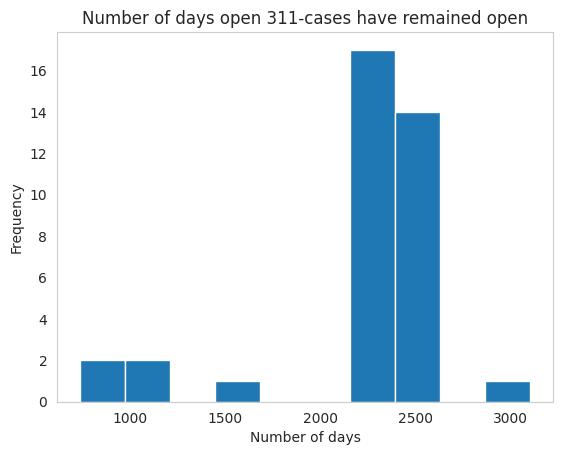

In [155]:
# hist to visaulize nbr of days open cases have remained open

# NOTE 
# Currently need to manually change the plot range to account 
# for range cases have been open, esp. in regard to the *mean*

sns.set_style("whitegrid", {'axes.grid' : False})
plt.title('Number of days open 311-cases have remained open')
plt.xlabel('Number of days')
#df_open['days_open'].plot(kind='hist', range=[500,5100], figsize=(9,5))
df_open['days_open'].plot(kind='hist')
plt.show()
# Note for 2500 rows, there are only 2 values for days_open

### Histograms processing time 

In [156]:
print('Quick stats on "processing days", use to set range on histogram')
print(df_closed.processing_days.agg([min, max, np.mean, np.median, statistics.mode]))

Quick stats on "processing days", use to set range on histogram
min         1.00000
max       806.00000
mean        5.59043
median      1.00000
mode        1.00000
Name: processing_days, dtype: float64


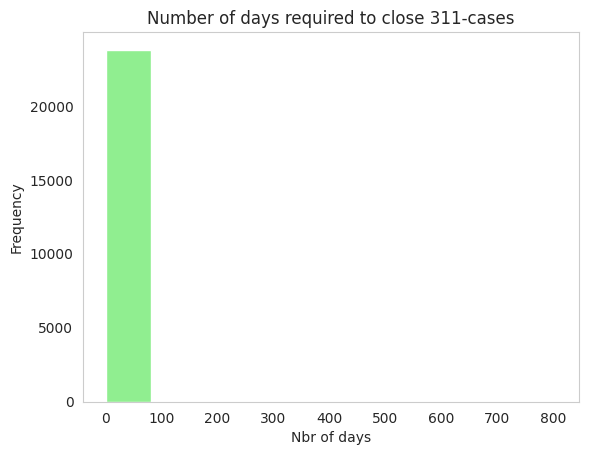

In [160]:
# hist to visualize processing time for cases that have been closed
plt.title('Number of days required to close 311-cases')
plt.xlabel('Number of days')
df_closed['processing_days'].plot(kind='hist', color='lightgreen')
plt.show()
# frequency scale is too broad to show any detail

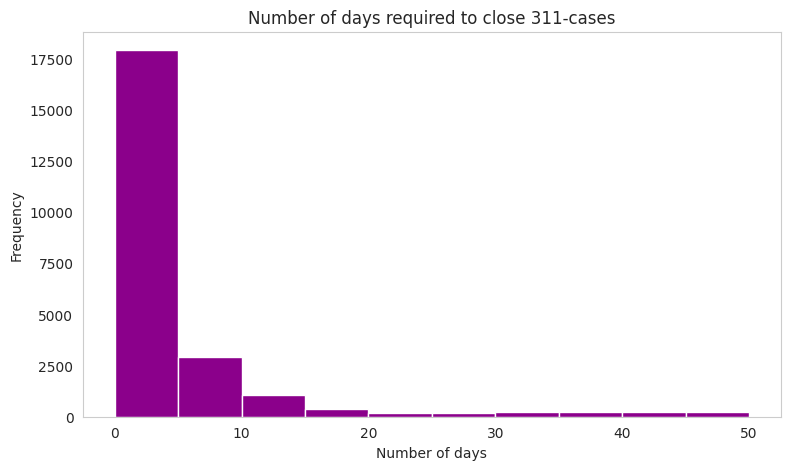

In [161]:
# hist to visualize processing time for cases that have been closed
plt.title('Number of days required to close 311-cases')
plt.xlabel('Number of days')
df_closed['processing_days'].plot(kind='hist', range=[0,50], color='DarkMagenta', figsize=(9,5))
plt.show()

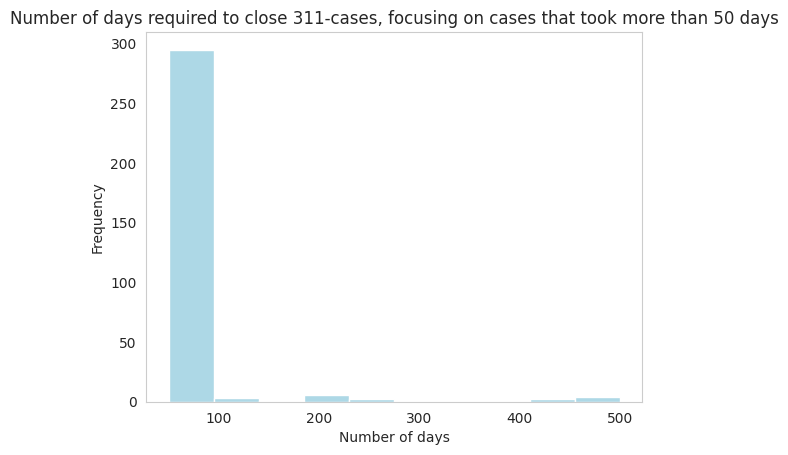

In [162]:
# hist to visualize processing time for cases that have been closed
plt.title('Number of days required to close 311-cases, focusing on cases that took more than 50 days')
plt.xlabel('Number of days')
#df_closed['processing_days'].plot(kind='hist', range=[100,900], color='LightBlue')
df_closed['processing_days'].plot(kind='hist', range=[50,500], color='LightBlue')
plt.show()

In [164]:
df_proc_less_100 = df_closed[df_closed['processing_days']<100]
df_proc_more_100 = df_closed[df_closed['processing_days']>99]

print(df_proc_less_100.shape)
print(df_proc_more_100.shape)

(23798, 18)
(27, 18)


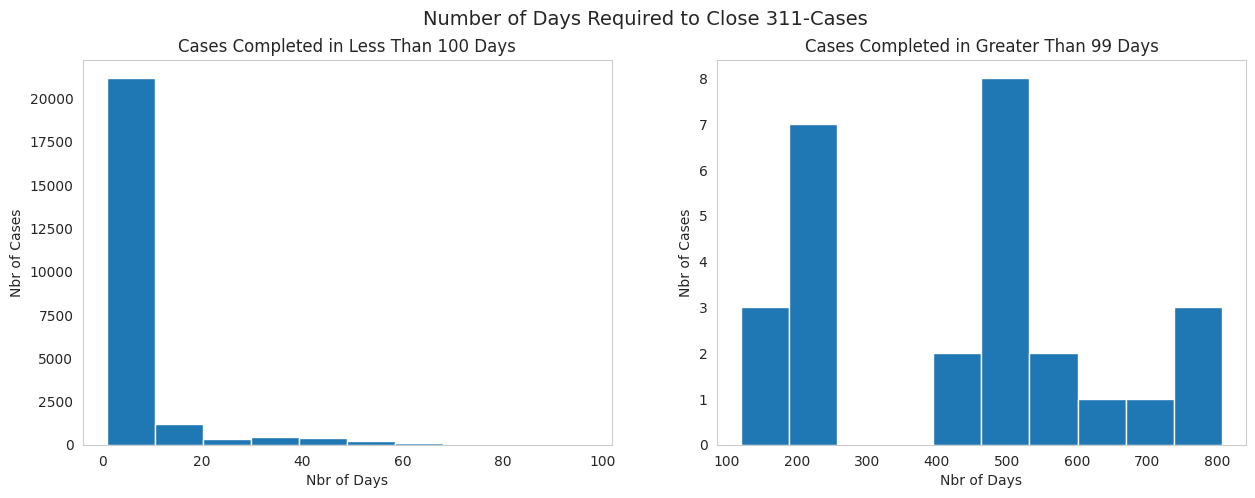

In [165]:
fig,ax =  plt.subplots(1,2, figsize=(15,5))

fig.suptitle('Number of Days Required to Close 311-Cases',fontsize=14)
ax[0].set(xlabel='Nbr of Days')
ax[1].set(xlabel='Nbr of Days')
ax[0].set(ylabel='Nbr of Cases')
ax[1].set(ylabel='Nbr of Cases')

ax[0].set_title('Cases Completed in Less Than 100 Days')
ax[1].set_title('Cases Completed in Greater Than 99 Days')

ax[0].hist(df_proc_less_100.processing_days)
ax[1].hist(df_proc_more_100.processing_days)
plt.show()

In [166]:
# break it into 3 blocks...
df_proc_less_50 = df_closed[df_closed['processing_days']<50]
df_proc_less_100 = df_closed[df_closed['processing_days'].between(50,100)]
df_proc_more_100 = df_closed[df_closed['processing_days']>99]

print(df_proc_less_50.shape)
print(df_proc_less_100.shape)
print(df_proc_more_100.shape)

(23501, 18)
(297, 18)
(27, 18)


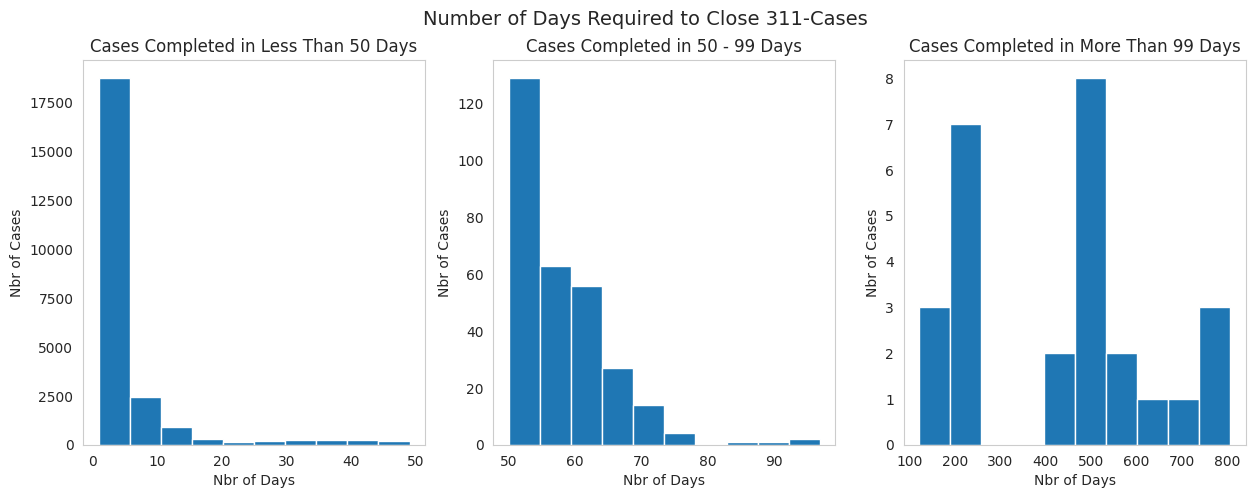

In [167]:
fig,ax =  plt.subplots(1,3, figsize=(15,5))
fig.suptitle('Number of Days Required to Close 311-Cases',fontsize=14)
for i in range(3):
  ax[i].set(xlabel='Nbr of Days')
  ax[i].set(ylabel='Nbr of Cases')
ax[0].set_title('Cases Completed in Less Than 50 Days')
ax[1].set_title('Cases Completed in 50 - 99 Days')
ax[2].set_title('Cases Completed in More Than 99 Days')

ax[0].hist(df_proc_less_50.processing_days)
ax[1].hist(df_proc_less_100.processing_days)
ax[2].hist(df_proc_more_100.processing_days)
plt.show()

# misleading because compares frequency scales that are completely diffefrent

In [168]:
del df_proc_less_50, df_proc_less_100, df_proc_more_100

### Plot, over time, nbr of days required to close cases

In [169]:
print('Processing days range:',df_closed.processing_days.min(),'to',df_closed.processing_days.max())

Processing days range: 1 to 806


In [171]:
# Create df with aggregate stats for month & year (reset_index to make opened_month_year a col)
grouped_df = df_closed.groupby('opened_year_month')['processing_days'].agg([np.mean, min, max]).reset_index()

# chg col names: 'process_mean' refers to mean nbr of days required to close a 311-case
grouped_df.rename(columns={'mean': 'closing_days_mean', 'min': 'closing_days_min', 'max':'closing_days_max'},inplace=True)
grouped_df.head()

,opened_year_month,closing_days_mean,closing_days_min,closing_days_max
0,2009-09,7.000000,7,7
1,2010-02,1.333333,1,3
2,2010-03,7.818182,1,66
3,2010-04,3.750000,1,10
4,2010-05,45.500000,1,90


In [172]:
grouped_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46 entries, 0 to 45
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype    
---  ------             --------------  -----    
 0   opened_year_month  46 non-null     period[M]
 1   closing_days_mean  46 non-null     float64  
 2   closing_days_min   46 non-null     int64    
 3   closing_days_max   46 non-null     int64    
dtypes: float64(1), int64(2), period[M](1)
memory usage: 1.6 KB


<ipython-input-72-9a389c6ba49d>:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i].set_xticklabels(labels, rotation='vertical')


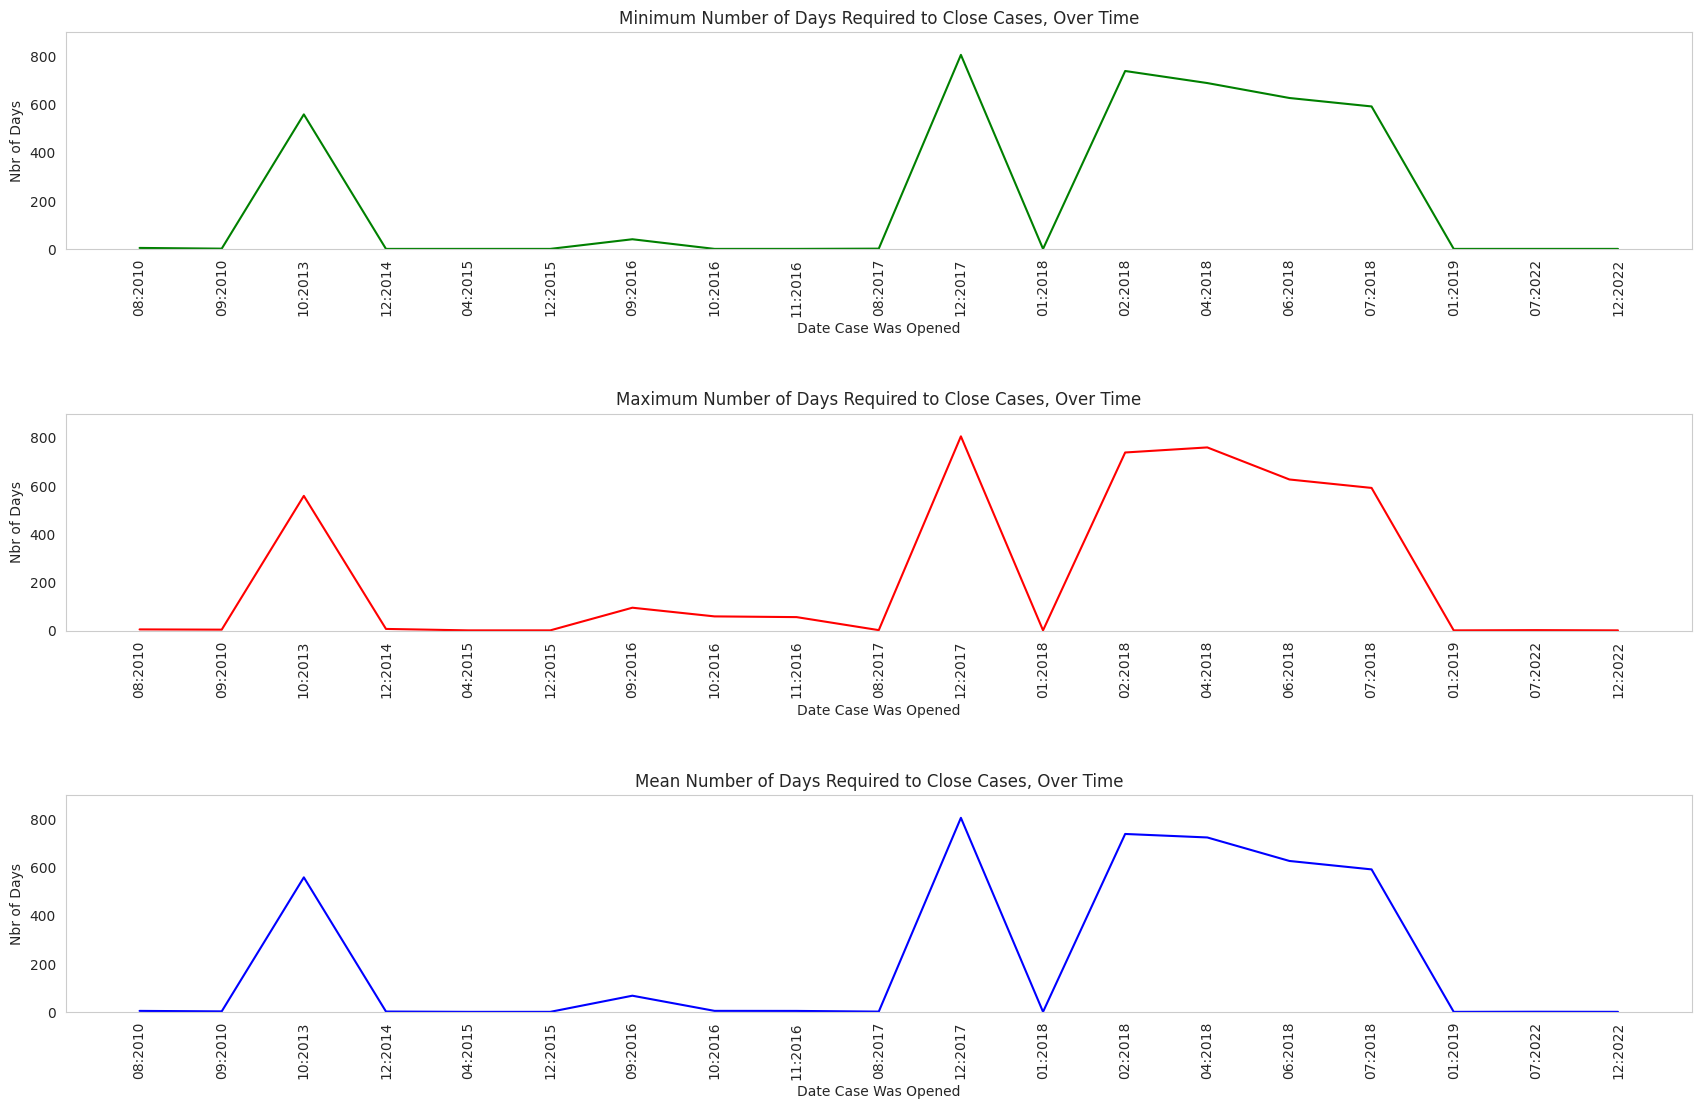

In [ ]:
# Visualize nbr of days it took to close cases, over time

# ISSUE [TODO]

# What was I trying to do here???

# when more recs were read time frame expaned; now x-axis labels are too close together
# could this be switched to the year, rather than the month?
# to do that, would need to create new col for year opened, then groupby that col

labels = grouped_df.opened_month_year.dt.strftime('%m:%Y').astype(str)
x = grouped_df.closing_days_max.max()
x_max = int(math.ceil(x / 100.0)) * 100

fig, ax = plt.subplots(3,1, figsize=(18,12))
for i in range(3):
  ax[i].set(ylabel='Nbr of Days')
  ax[i].set_xticklabels(labels, rotation='vertical')
  ax[i].set(xlabel='Date Case Was Opened')
  ax[i].set_ylim([0, x_max]) # makes y scale same on all 3

ax[0].set_title('Minimum Number of Days Required to Close Cases, Over Time')
ax[1].set_title('Maximum Number of Days Required to Close Cases, Over Time')
ax[2].set_title('Mean Number of Days Required to Close Cases, Over Time')
fig.tight_layout(pad=4.0)
'''
annotate start of pandemic?
ax.annotate('pixel offset from axes fraction',
            xy=(1, 0), xycoords='axes fraction',
            xytext=(-20, 20), textcoords='offset pixels',
            horizontalalignment='right',
            verticalalignment='bottom')
'''
ax[0].plot(grouped_df.opened_month_year.dt.strftime('%m:%Y'), grouped_df.closing_days_min, color='g')
ax[1].plot(grouped_df.opened_month_year.dt.strftime('%m:%Y'), grouped_df.closing_days_max, color='r')
ax[2].plot(grouped_df.opened_month_year.dt.strftime('%m:%Y'), grouped_df.closing_days_mean, color='b')
plt.show()

In [ ]:
# Create df with aggregate stats for month & year (reset_index to make opened_month_year a col)
year_df = df_closed.groupby('opened_year')['processing_days'].agg([np.mean, min, max]).reset_index()

# chg col names: 'process_mean' refers to mean nbr of days required to close a 311-case
year_df.rename(columns={'mean': 'closing_days_mean', 'min': 'closing_days_min', 'max':'closing_days_max'},inplace=True)
year_df.head()

,opened_year,closing_days_mean,closing_days_min,closing_days_max
0,2010,3.666667,2,5
1,2013,559.000000,559,559
2,2014,2.333333,1,7
3,2015,1.000000,1,1
4,2016,5.013203,1,95


In [ ]:
del grouped_df

<ipython-input-75-2ba42fe16abd>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i].set_xticklabels(labels)


AttributeError: ignored

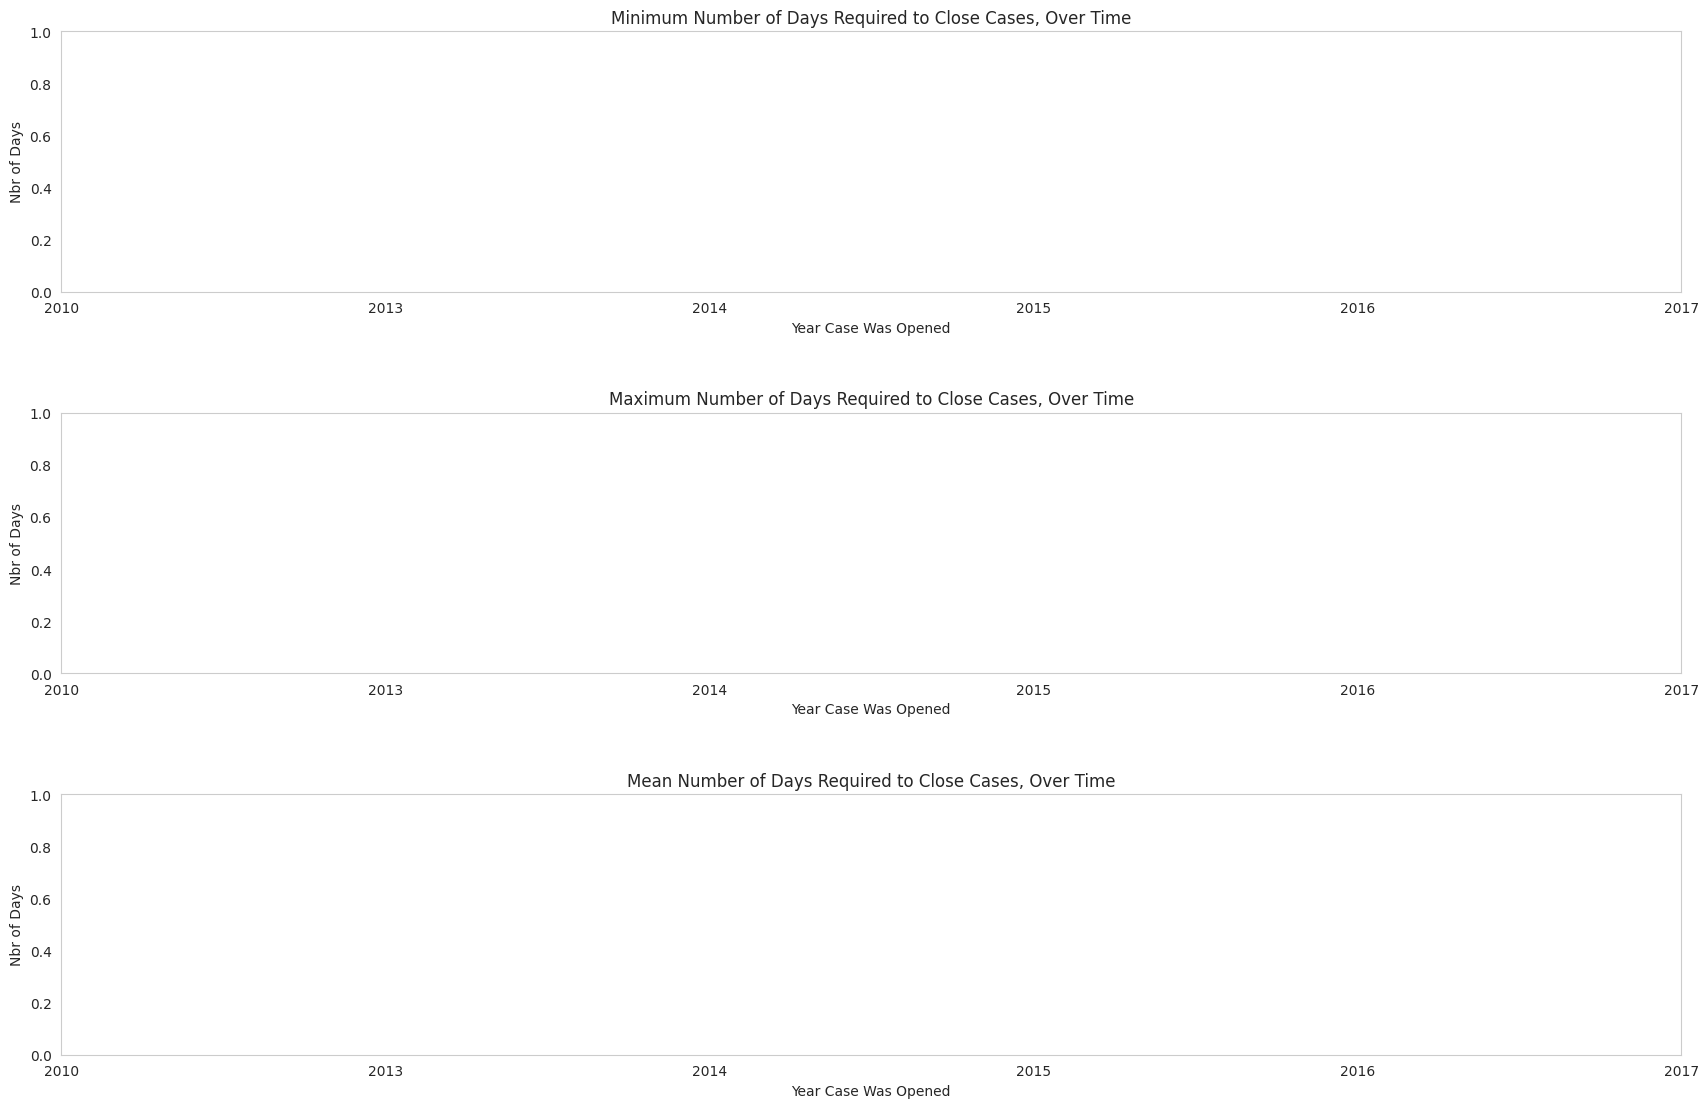

In [ ]:
# same visualization, but at yearly intervals
# NOTE that the y-axis scales are NOT the same

#TODO change this to match the current way I populate opened_year

#labels = year_df.opened_year.dt.strftime('%Y').astype(str)
labels = year_df.opened_year.astype(str)

x = year_df.closing_days_max.max()
x_max = int(math.ceil(x / 100.0)) * 100

fig, ax = plt.subplots(3,1, figsize=(18,12))
for i in range(3):
  ax[i].set(ylabel='Nbr of Days')
  ax[i].set_xticklabels(labels)
  ax[i].set(xlabel='Year Case Was Opened')
#  ax[i].set_ylim([0, x_max]) # makes y scale same on all 3

ax[0].set_title('Minimum Number of Days Required to Close Cases, Over Time')
ax[1].set_title('Maximum Number of Days Required to Close Cases, Over Time')
ax[2].set_title('Mean Number of Days Required to Close Cases, Over Time')
fig.tight_layout(pad=4.0)

ax[0].plot(year_df.opened_year.dt.strftime('%Y'), year_df.closing_days_min, color='lightgreen')
ax[1].plot(year_df.opened_year.dt.strftime('%Y'), year_df.closing_days_max, color='plum')
ax[2].plot(year_df.opened_year.dt.strftime('%Y'), year_df.closing_days_mean, color='lightblue')
plt.show()

### Changes over time: has the source changed over time?

### Plot closed cases 
  as a Series by: 

*   Responsible Agency
*   Category
*   Request Type
*   Supervisor District
*   Neighborhood
*   Police Disctrict




In [ ]:
# plot CLOSED cases (as a Series) by: Responsible Agency, Category, 
#  Request Type, Supervisor District, Neighborhood, Police District
# 'ranking relationship' so using horizontal bar graphs
# for Supervisor District, maybe join to diff table to get supervisor name (based on date)?

elements = ['Responsible Agency','Category', 'Request Type',
            'Supervisor District', 'Neighborhood', 'Police District']

for el in elements:
  plt.title('Most Common '+ el+' for Closed 311-Cases')
  plt.xlabel('Count')
  df_closed[el].value_counts().nlargest(n=8).sort_values().plot(kind='barh',color='g')
  plt.show()


### Plot open cases 
 as a Series by: 

*   Responsible Agency
*   Category
*   Request Type
*   Supervisor District
*   Neighborhood
*   Police Disctrict

In [ ]:
#  Supervisor District (could join to a diff table to get supervisor name)
# 'ranking relationship' so using horizontal bar graphs

# When considering 'open' cases, focus on cases that have remained open for a lengthy period
# (If a case opened yesterday is still open, that doesn't indicate an issue)

# only consider cases open for at least a year...
df_open_long = df_open[df_open['time_open'].astype('timedelta64[D]') > 365]

for e in elements:
  plt.title('Most Common '+ e+' for Open 311-Cases')
  plt.xlabel('Count')
  df_open_long[e].value_counts().nlargest(n=8).sort_values().plot(kind='barh', color='r')
  plt.show()

## **Question**: Are the most common Closed case types the same as the most common Open case types? Should I be looking at percentages instead? Relative to total number of cases?

## Correlation between [something?] and 'closure rate'
### must define 'closure rate'